# "A Journey Through Fastbook (AJTFB) - Chapter 6: Regression"
> "Its the more things you can do with computer vision chapter of [\"Deep Learning for Coders with fastai & PyTorch\"](https://github.com/fastai/fastbook)! Having looked at both multiclass and multilable classification, we now turn our attention to regression tasks. In particular, we'll look at key point regression models covered in chapter 6. Soooo lets go!"

- toc: true
- branch: master
- badges: true
- hide_binder_badge: true
- comments: true
- author: Wayde Gilliam
- categories: [fastai, fastbook, regression, computer vision, key point]
- image: images/articles/fastbook.jpg
- search_exclude: false
- hide: false

Other posts in this series:  
[A Journey Through Fastbook (AJTFB) - Chapter 1](https://ohmeow.com/posts/2020/11/06/ajtfb-chapter-1.html)  
[A Journey Through Fastbook (AJTFB) - Chapter 2](https://ohmeow.com/posts/2020/11/16/ajtfb-chapter-2.html)  
[A Journey Through Fastbook (AJTFB) - Chapter 3](https://ohmeow.com/posts/2020/11/22/ajtfb-chapter-3.html)  
[A Journey Through Fastbook (AJTFB) - Chapter 4](https://ohmeow.com/posts/2021/05/23/ajtfb-chapter-4.html)  
[A Journey Through Fastbook (AJTFB) - Chapter 5](https://ohmeow.com/posts/2021/06/03/ajtfb-chapter-5.html).  
[A Journey Through Fastbook (AJTFB) - Chapter 6a](https://ohmeow.com/posts/2021/06/10/ajtfb-chapter-6-multilabel.html)



In [1]:
#hide
! pip install fastai -Uqq

In [2]:
#hide
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

---
## Regression

A **regression** task is all about predicting a [continous](https://ohmeow.com/posts/2020/11/06/ajtfb-chapter-1.html#Continuous-datatypes) value rather than a particular cateogry.

Here we'll consider a particular type of regression problem called ***image regression***, where the "independent variable is an image, and the dependent variable is one or more float."  Our model is going to be a ***key point*** model that aims to predict a point (e.g., 2 labels ... the x and y) on the image, which in our example is the center of a person's face.

---
## Defining your DataBlock

Again, the `DataBlock` is a blueprint for everything required to turn your raw data (images and labels) into something that can be fed through a neural network (DataLoaders with a numerical representation of both your images and labels).  Below is the one presented in this chapter.



In [3]:
from fastai.vision.all import *
path = untar_data(URLs.BIWI_HEAD_POSE)

path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/02.obj'),Path('/root/.fastai/data/biwi_head_pose/04'),Path('/root/.fastai/data/biwi_head_pose/10'),Path('/root/.fastai/data/biwi_head_pose/17.obj'),Path('/root/.fastai/data/biwi_head_pose/23.obj'),Path('/root/.fastai/data/biwi_head_pose/21.obj'),Path('/root/.fastai/data/biwi_head_pose/24.obj'),Path('/root/.fastai/data/biwi_head_pose/12.obj'),Path('/root/.fastai/data/biwi_head_pose/10.obj'),Path('/root/.fastai/data/biwi_head_pose/01')...]

"There are 24 directories numbered from 01 to 24 (they corresond to the different people photographed), and a corresponding *.obj* file for each (we won't need them here)

> Tip: Always EDA your dataset to make sure you understand how it is organized; this is especially important to ensure you create a good validation set without leakage from the training set.


> Note: "... we should not just use a random splitter [so as] to ensure that our model can generalize to people that it hasn't seen yet; a splitter function that returns True for just one person, resulting in a validation set containing just that one person."

In [4]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00486_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00023_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00122_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00165_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00167_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00384_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00287_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00075_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00186_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00444_rgb.jpg')...]

Looks like each person has multiple images, and for each image there is a text file telling us where the point is. We can write a function to get the .txt file for any given image as such

In [5]:
img_files = get_image_files(path)

def img2pose(img_fpath):
  return Path(f"{str(img_fpath)[:-7]}pose.txt")

img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/04/frame_00486_pose.txt')

> Tip: Look at your inputs/targets to verify you're understanding of them is correct

(480, 640)


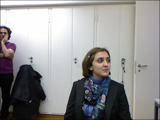

In [6]:
img = PILImage.create(img_files[0])
print(img.shape)
img.to_thumb(160)

And the books provides the function to use to extract the x/y (point) which is given as ...

In [7]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

def get_img_center(img_fpath):
  ctr = np.genfromtxt(img2pose(img_fpath), skip_header=3)
  x = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  y = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]

  return tensor([x,y])

In [8]:
get_img_center(img_files[0])

tensor([416.9190, 250.1563])

And with the above info and methods, we can now construct our `DataBlock`

In [15]:
dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_img_center,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)]
)

**Let's break down our blueprint**!

1. Define the data types for our inputs and targets via the `blocks` argument.

  Here our targets are of type `PointBlock`. "This is necessary so that fastai knows that the labels represent coordinates ... ***it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images.***"

2. Define how we're going to get our images via `get_items`.

  Can just use the `get_image_files` since we will be passing the `path` into our `DataBlock.dataloaders()` method

3. Define how, from the raw data, we're going to create our labels via `get_y`.

  Will simply use the `get_img_center` we defined above since we will get getting a bunch of paths to images.

4. Define how we're going to create our [validation dataset](https://www.fast.ai/2017/11/13/validation-sets/) via `splitter`

  Here we define a custom splitter using `FuncSplitter`, which gives us complete control in how our validation set is determined.  Here it will be all the images associated to person "13".

5. Define things we want to do for each item via `item_tfms`

  Nothing for this example

6. Define things we want to do for each mini-batch of items via `batch_tfms`

  For each minibatch of data, we'll resize each image to 320x240 pixels and apply the default augmentations specified in `aug_transforms`.  We'll also normalize our images used the ImageNet mean/standard deviations since our pretrained model was trained on ImageNet.



> Note: If you want to serialize your `Learner`, do not use lambda functions for defining your DataBlock methods! They can't be pickled.

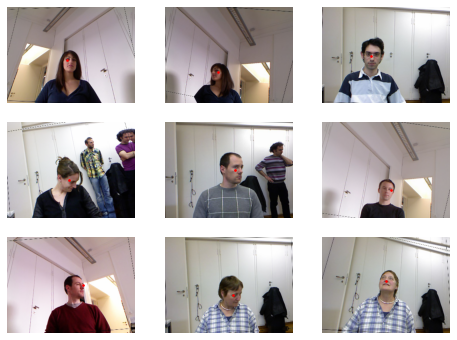

In [20]:
dls = dblock.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

To get a feel for what our `item_tfms` and `batch_tfms` are doing, we can `show_batch` using a single image as we do below.

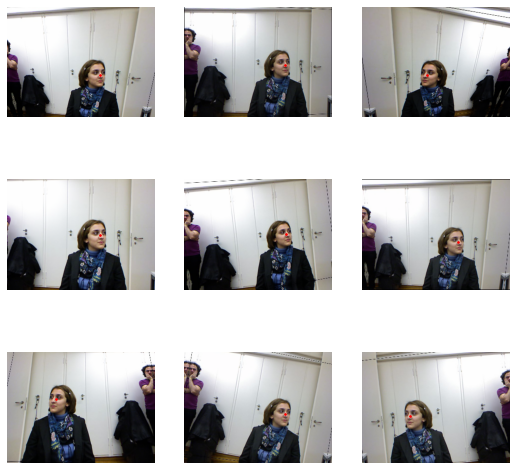

In [19]:
dls.show_batch(unique=True)

> Tip: It is recommended to see what the tensors look like as well

In [22]:
xb, yb = dls.one_batch()
xb.shape, yb.shape, yb[0]

(torch.Size([64, 3, 240, 320]),
 torch.Size([64, 1, 2]),
 TensorPoint([[0.2772, 0.0728]], device='cuda:0'))

---
## Train a model

> Important: "Once you think your data looks right, we generally recommend the next step should be using it to train a simple model" See bottom of p193 for why.

### `y_range`

> Tip: [`y_range`](https://ohmeow.com/posts/2020/11/06/ajtfb-chapter-1.html#What-if-our-target-is-continuous?) should be used in regression tasks to narrow down the valid range of our targets.


It's implementation in fastai is:
```python
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo
```

... and looks like this when plotted:

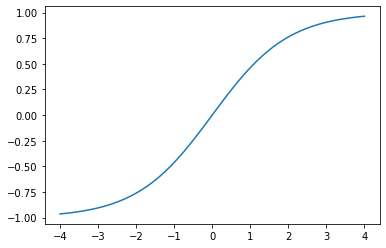

In [27]:
plot_function(partial(sigmoid_range,low=-1,high=1), min=-4, max=4)

> Note: Since we know "coordinates in fastai and PyTorch are always rescaled between -1 and 1, we can use those values when defining our `Learner`

### Define your loss function

As we didn't define a loss function, fastai will pick one for us based on our task.  Here is will be `MSELoss` (mean squared loss).

"... when coordinates are used as the dependent variable, most of the time we're likely to be trying to predict something as close as possible; that's basically what `MSELoss` does"

In [28]:
dls.loss_func

FlattenedLoss of MSELoss()

### Metrics

> Tip: "... MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root"

### Define our `Learner` and start training

In [30]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

SuggestedLRs(valley=0.0008317637839354575)

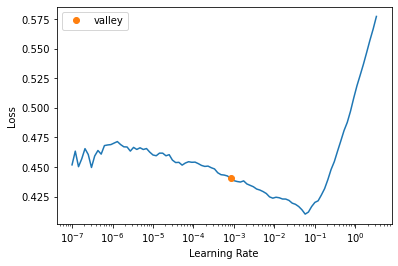

In [31]:
learn.lr_find()

In [32]:
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,time
0,0.049521,0.008220,02:13
1,0.007028,0.001976,01:56
2,0.003018,0.001024,01:56
3,0.001997,0.000425,01:56
4,0.001606,0.000190,01:56


"Generally when we run this we got a loss of around 0.0001, which correspondes to this average coordinate prediction error:"

```python
math.sqrt(0.0001) 
# 0.01
```

This is pretty accurate ...

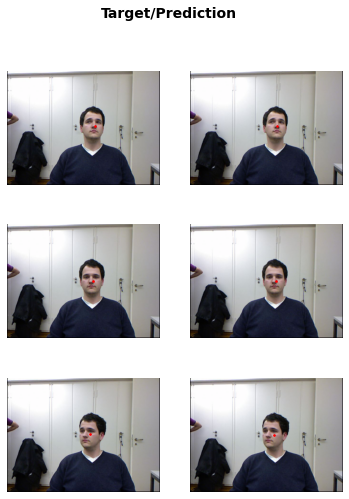

In [33]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))

---
## Summary

Pick your loss and metrics according to your task ...

For single-label classification: `nn.CrossEntropyLoss` and accuracy, precision, recall, f1, etc...

For multi-label classification: `nn.BCEWithLogitsLoss` and accuracy, precision, recall, f1, etc...

For regression: `nn.MSELoss` and the square root of the validation loss as the metric


---

## Resources

1. https://book.fast.ai - The book's website; it's updated regularly with new content and recommendations from everything to GPUs to use, how to run things locally and on the cloud, etc...
